# Intro to Data Science
## Part IX. - Building a GPT

### Table of contents
- I. Input data: Petőfi's poems
- II. Create a simple stochastic generative model
- III. Create a (decoder) Transformer network


### DISCLAIMERs:

1. This is a companion notebook to Karpathy's [Zero To Hero](https://karpathy.ai/zero-to-hero.html) video on GPT which was modified slightly to better fit SZISZ's intro to Data Science course. To have a more detailed session about the building of this code, follow along [Andrej](https://www.youtube.com/@AndrejKarpathy)'s [video lecture](https://www.youtube.com/watch?v=kCc8FmEb1nY).

2. This notebook uses pictures captured from [The A.I. Hacker - Michael Phi](https://www.youtube.com/@thea.i.hacker-michaelphi6569)'s video called [Illustrated Guide to Transformers Neural Network: A step by step explanation](https://www.youtube.com/watch?v=4Bdc55j80l8) to present the transformer architecture.

3. You are not supposed to execute this notebook on your computer, instead upload it to [Google Colab](https://colab.research.google.com/) along with the required data file (`data/perofi_all.txt`).

4. Check out [3Blue1Brown](https://www.youtube.com/playlist?list=PLZHQObOWTQDNU6R1_67000Dx_ZCJB-3pi)'s video series on the topic.

# I. Input data: Petőfi's

In [ ]:
# Mount our google drive to read the data from
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# read the data in to inspect it
with open('/content/drive/MyDrive/Colab Notebooks/petofi_all.txt', 'r', encoding='utf-8') as f:
    text = f.read()

print("length of dataset in characters: ", len(text))

In [ ]:
# let's look at the first 1000 characters
print(text[:1000])

## Prepare for modeling

In [ ]:
import tqdm

import torch  # we use PyTorch: https://pytorch.org
import torch.nn as nn
from torch.nn import functional as F

# Set a global seed for the notebook
torch.manual_seed(42)

In [ ]:
# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
print(''.join(chars))
print(vocab_size)

In [ ]:
# create a mapping from characters to integers
stoi = {ch: i for i, ch in enumerate(chars)}
itos = {i: ch for i, ch in enumerate(chars)}
encode = lambda s: [stoi[c] for c in s]          # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

print(encode("Szervusz Kedvesem!"))
print(decode(encode("Szervusz Kedvesem!")))

In [ ]:
# let's now encode the entire text dataset and store it into a torch.Tensor
data = torch.tensor(encode(text), dtype=torch.long)
print(data.shape, data.dtype)
print(data[:1000]) # the 1000 characters we looked at earier will to the GPT look like this

In [ ]:
# Let's now split up the data into train and validation sets
n = int(0.9 * len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

In [ ]:
block_size = 8
train_data[:block_size+1]

In [ ]:
x = train_data[:block_size]
y = train_data[1:block_size+1]

for t in range(block_size):
    context = x[:t+1]
    target = y[t]
    print(f"when input is {context} the target: {target}")
    print(f"when input is `{decode(context.tolist())}` the target: `{itos.get(int(target), '')}`")

In [ ]:
batch_size = 4 # how many independent sequences will we process in parallel?
block_size = 8 # what is the maximum context length for predictions?


def get_batch(data, batch_size=batch_size, block_size=block_size):
    # generate a small batch of data of inputs x and targets y
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    return x, y


xb, yb = get_batch(train_data, batch_size, block_size)
print('inputs:')
print(xb.shape)
print(xb)
print('targets:')
print(yb.shape)
print(yb)
print('----')


for b in range(batch_size):     # batch dimension
    for t in range(block_size): # time dimension
        context = xb[b, :t+1]
        target = yb[b, t]
        print(f"when input is {context.tolist()} the target: {target}")
        print(f"when input is `{decode(context.tolist())}` the target: `{itos.get(int(target), '')}`")
    print('-'*40)

In [ ]:
print(xb)  # our input to the transformer

# II. Create a simple stochastic generative model

Naming convention:
- **B**: Batch, the number of examples in a single forward step
- **T**: Time, the size of the context in each example
- **C**: Channel, the size of the embedding vector

Our goal is to learn the transitional probabilities for each token (character).

Example:
For a batch of 1 example (B=1), of a single `'?'` token (T=1), we have the index tensor with the size `(B, T)` -> `(1, 1)`:
```python
tensor([[ 21 ]])
```
For the initial embedding vector (C=104), we have
```python
tensor([[[ 0.2365,  0.0220, ...,  -1.3688, -0.7238]]])
```
The index shape is now `(B, T, C)` -> `(1, 1, 104)`. To get the predicted next token, we'll transform the embedding vector into probabilites using the softmax function, and then generate a random sample from the probability vector.

In [ ]:
class BigramLanguageModel(nn.Module):

    def __init__(self, vocab_size):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(num_embeddings=vocab_size,  # initialized randomly, from N(0, 1)
                                                  embedding_dim=vocab_size)

    def forward(self, idx, targets=None):

        # idx and targets are both (B, T) tensor of integers
        logits = self.token_embedding_table(idx) # (B, T, C)

        if targets is None:
            loss = None

        else:
            B, T, C = logits.shape
            logits = logits.view(B * T, C)  # reshape to match cross_entropy params
            targets = targets.view(B * T)   # reshape to match cross_entropy params
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # get the predictions (calls .forward())
            logits, loss = self(idx)
            # focus only on the last time step (drop the T dimension, gets the last context for pred)
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution (pick one token based on the token probabilities)
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

In [ ]:
bigram_model = BigramLanguageModel(vocab_size)
logits, loss = bigram_model(xb, yb)
print(logits.shape)
print(loss)

# generate a sequence, starting with '\n' (vocab index: 0)
idx = torch.zeros((1, 1), dtype=torch.long)
generated_tokens = bigram_model.generate(idx=idx, max_new_tokens=100) # (B, T) -> (1, 100)
generated_text = decode(generated_tokens[0].tolist()) # (T,) -> (100,) -> python list of len 100 -> str of len 100
print(generated_text)

In [ ]:
# create a PyTorch optimizer
optimizer = torch.optim.AdamW(bigram_model.parameters(), lr=1e-3)  # embedding tensor

In [ ]:
batch_size = 32
for steps in tqdm.trange(10000):  # increase number of steps for good results...

    # sample a batch of data
    xb, yb = get_batch(train_data, batch_size, block_size)

    # evaluate the loss
    logits, loss = bigram_model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

print(loss.item())

In [ ]:
# generate a sequence, starting with '\n' (vocab index: 0)
idx = torch.zeros((1, 1), dtype=torch.long)
generated_tokens = bigram_model.generate(idx=idx, max_new_tokens=500) # (B, T) -> (1, 500)
generated_text = decode(generated_tokens[0].tolist()) # (T,) -> (500,) -> python list of len 500 -> str of len 500
print(generated_text)

# III. Create a (decoder) Transformer network


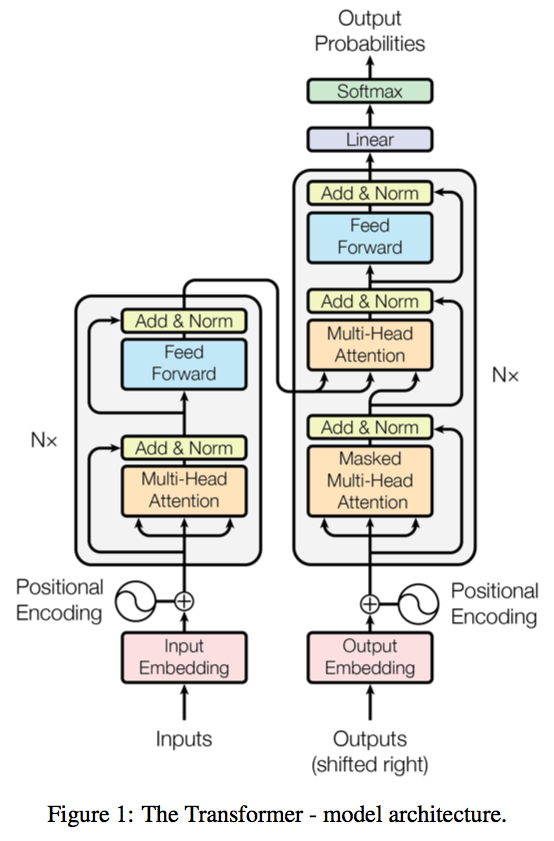


This section is based on the 2017 paper called [Attention is all you need](https://arxiv.org/pdf/1706.03762.pdf). It describes a network which is capable of encoding and then decoding text. The aim of this paper is to introduce a novel technique to machine translation via the attention mechanism.

In this notebook we aim to create a generative model so we are skipping the encoding part of this architecture - however the two sides (encoder and decoder) has very similar building blocks.

The basic steps of this architectures follows:

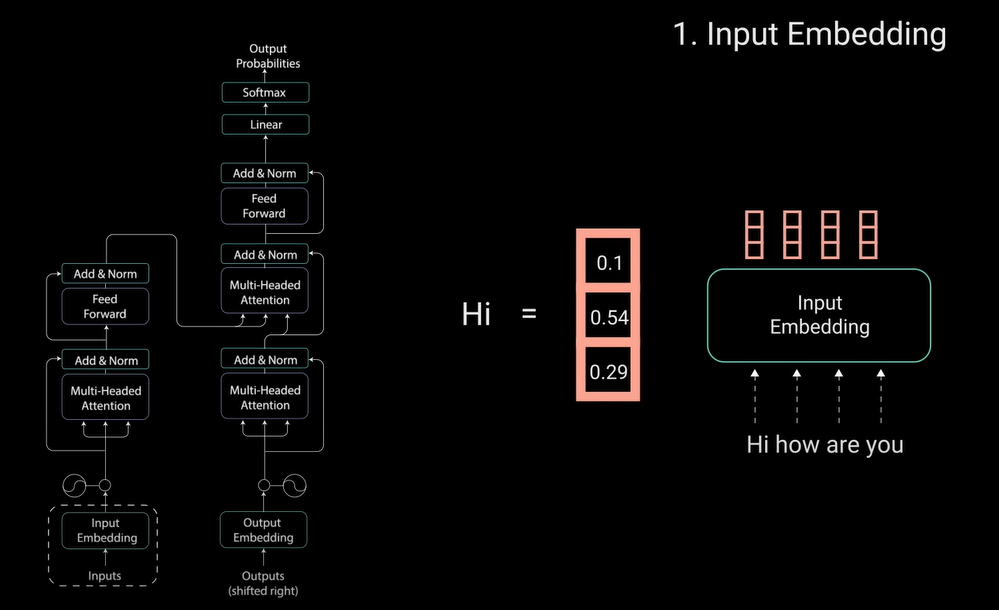

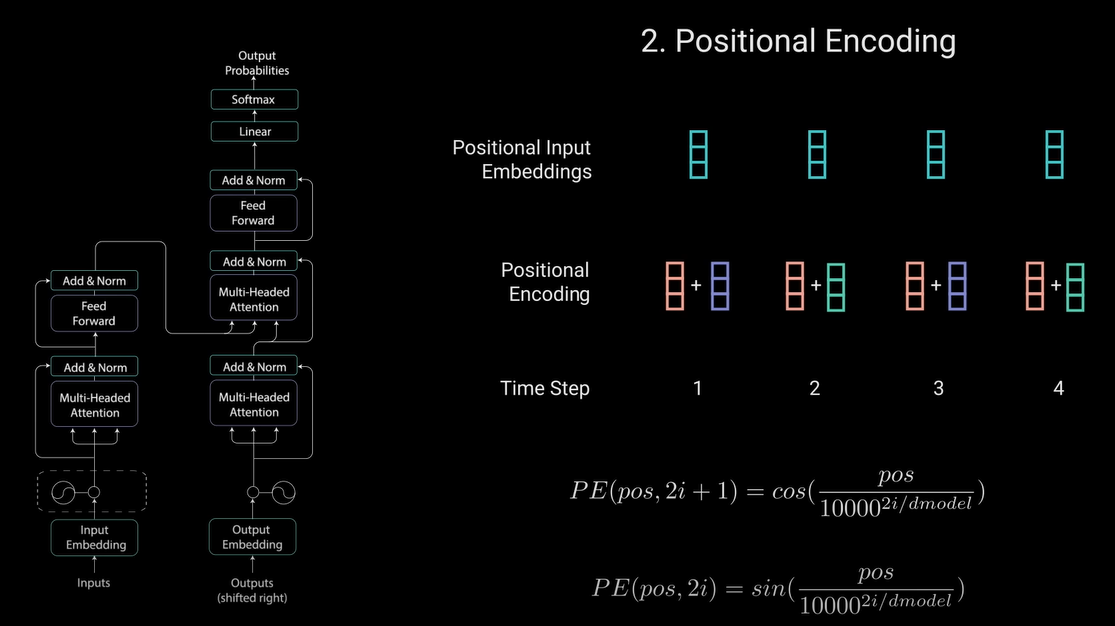

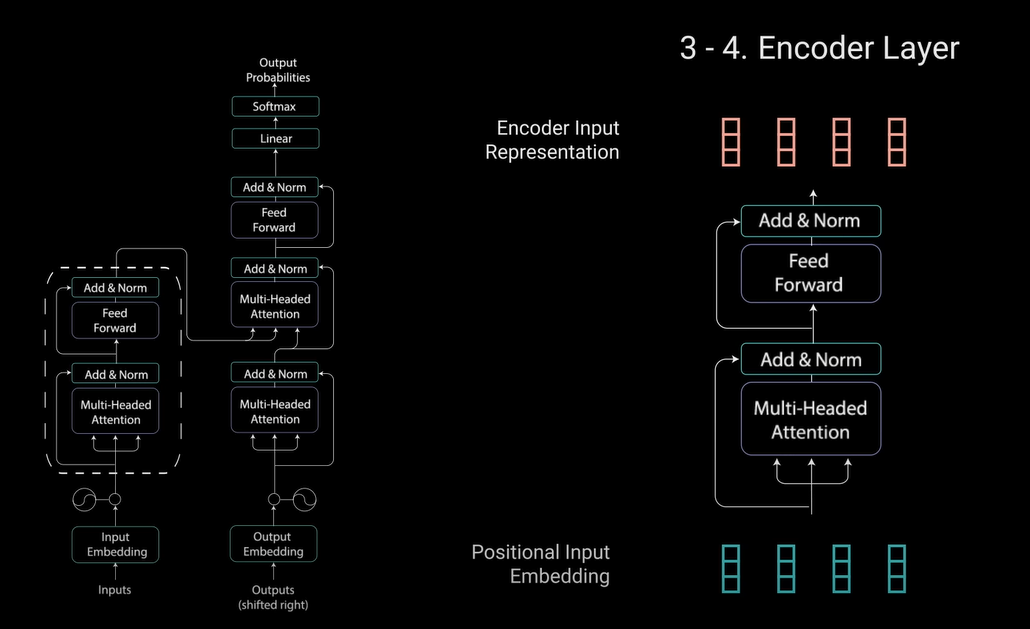

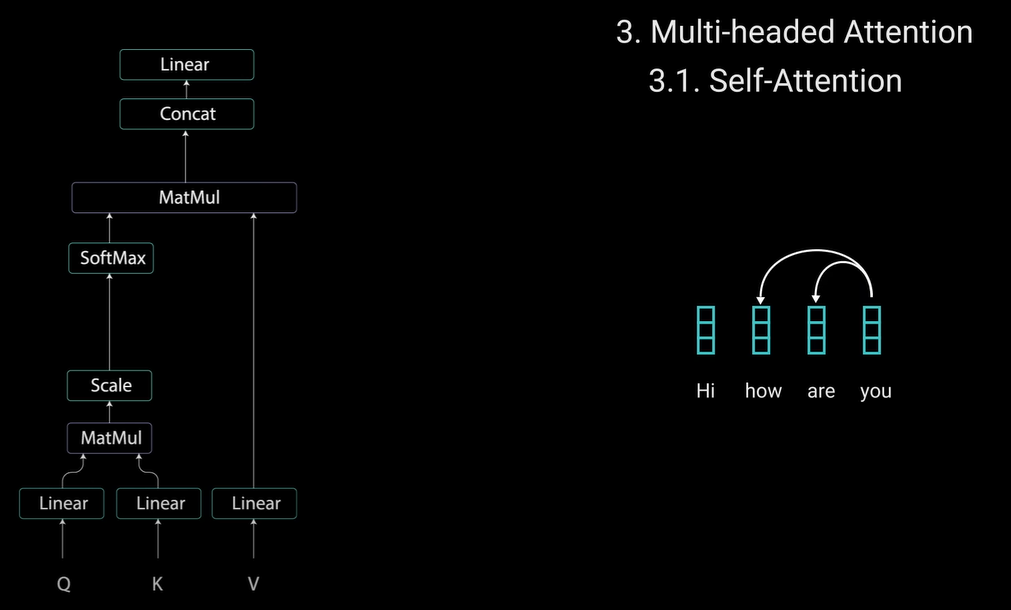

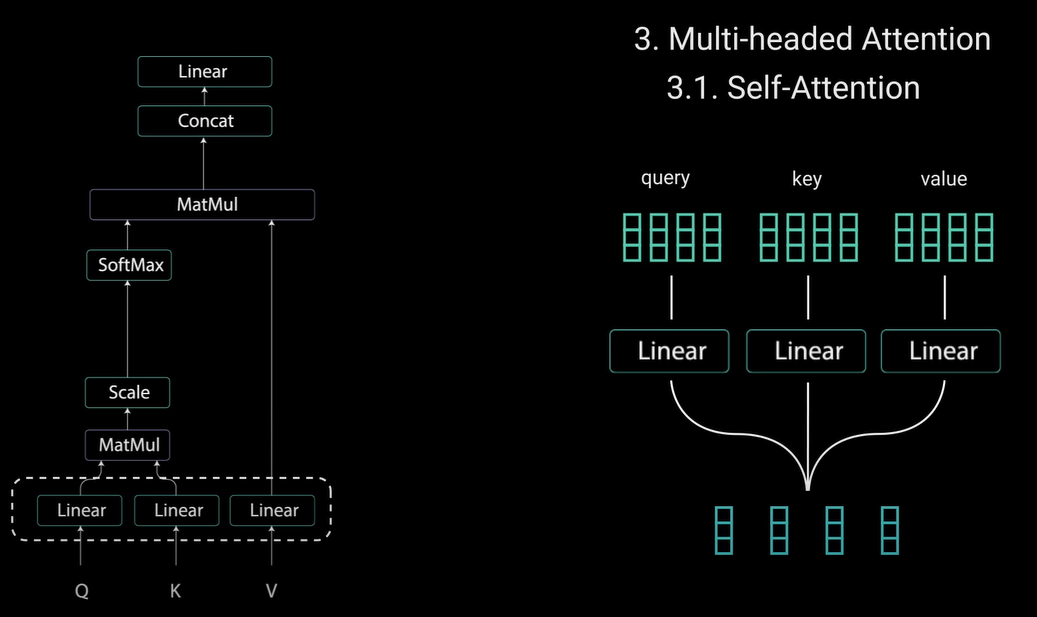

Keys, Queries, and Values: https://stats.stackexchange.com/questions/421935/what-exactly-are-keys-queries-and-values-in-attention-mechanisms

> The key/value/query concept is analogous to retrieval systems. For example, when you search for videos on Youtube, the search engine will map your **query**(text in the search bar) against a set of **keys** (video title, description, etc.) associated with candidate videos in their database, then present you the best matched videos (**values**).

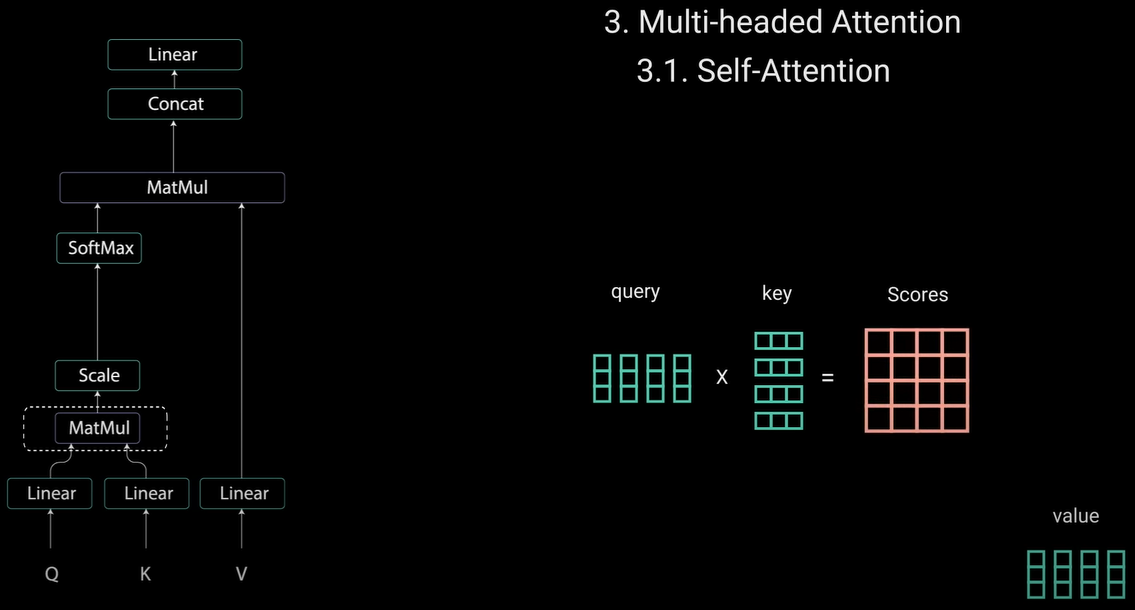

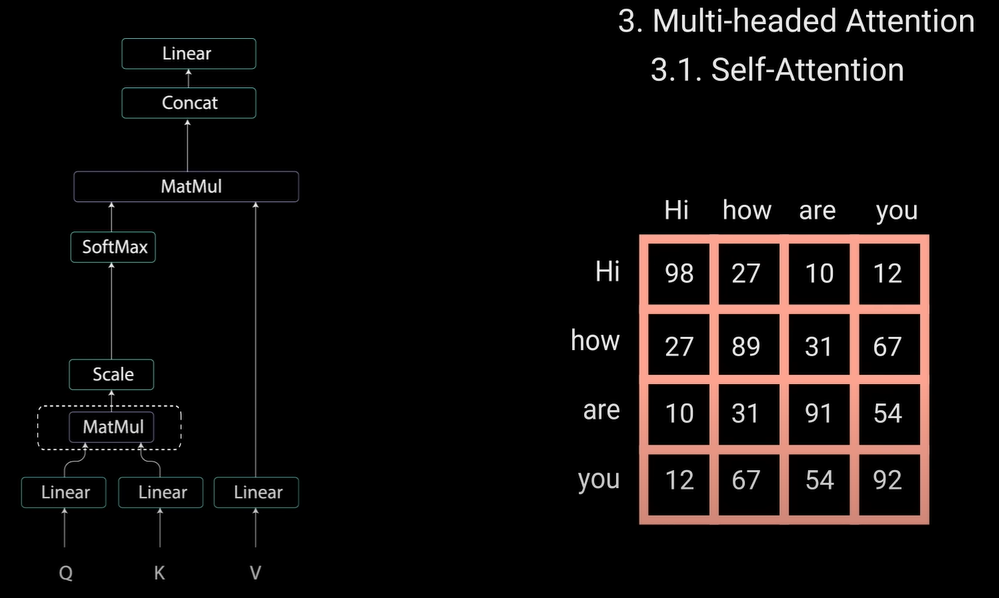

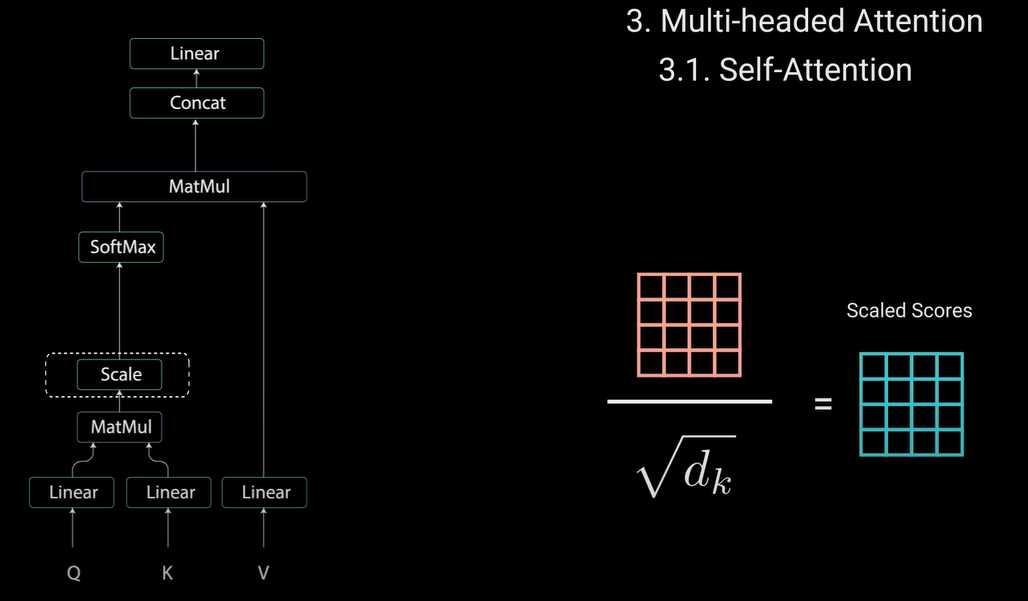

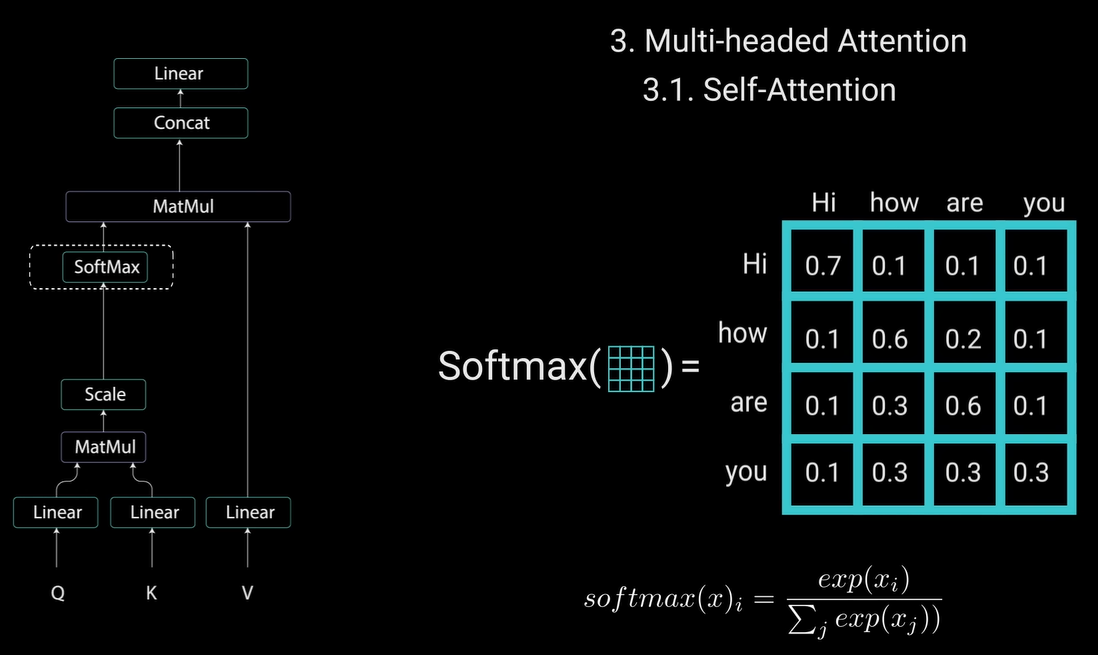

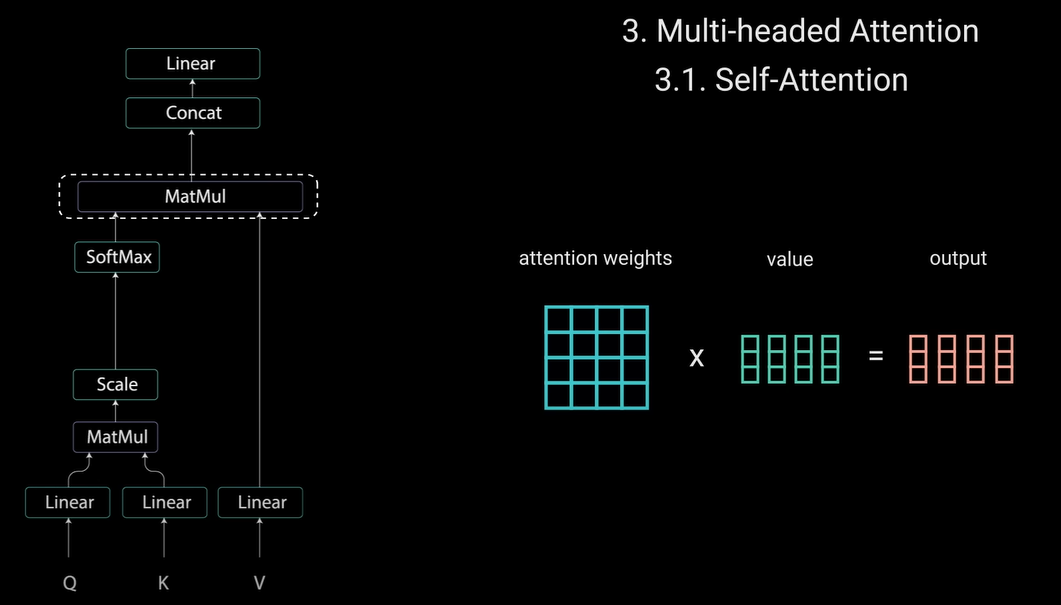

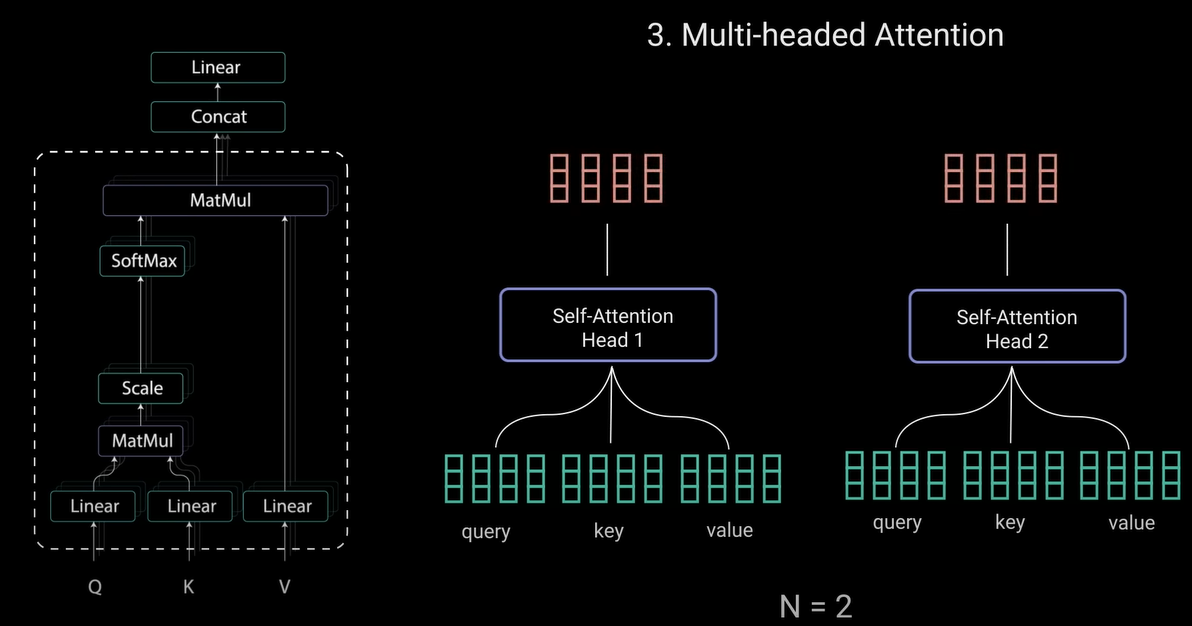

## The mathematical trick in self-attention

In [ ]:
# toy example illustrating how matrix multiplication can be used for a "weighted aggregation"
a = torch.tril(torch.ones(3, 3))
a = a / torch.sum(a, 1, keepdim=True)
b = torch.randint(0, 10, (3, 2)).float()
c = a @ b

print('a=')
print(a)
print('--')
print('b=')
print(b)
print('--')
print('c=')
print(c)

In [ ]:
# consider the following toy example:
B, T, C = 4, 8, 2 # batch, time, channels
x = torch.randn(B, T, C)
x.shape

In [ ]:
# We want x[b, t] = mean_{i<=t} x[b, i]
xbow = torch.zeros((B, T, C))
for b in range(B):
    for t in range(T):
        xprev = x[b, :t+1] # (t, C)
        xbow[b,t] = torch.mean(xprev, 0)

In [ ]:
# version 2: using matrix multiply for a weighted aggregation
wei = torch.tril(torch.ones(T, T))
wei = wei / wei.sum(1, keepdim=True)
xbow2 = wei @ x # (B, T, T) @ (B, T, C) ----> (B, T, C)
torch.allclose(xbow, xbow2)

In [ ]:
# version 3: use Softmax
tril = torch.tril(torch.ones(T, T))
wei = torch.zeros((T,T))
wei = wei.masked_fill(tril == 0, float('-inf'))
wei = F.softmax(wei, dim=-1)
xbow3 = wei @ x
torch.allclose(xbow, xbow3)

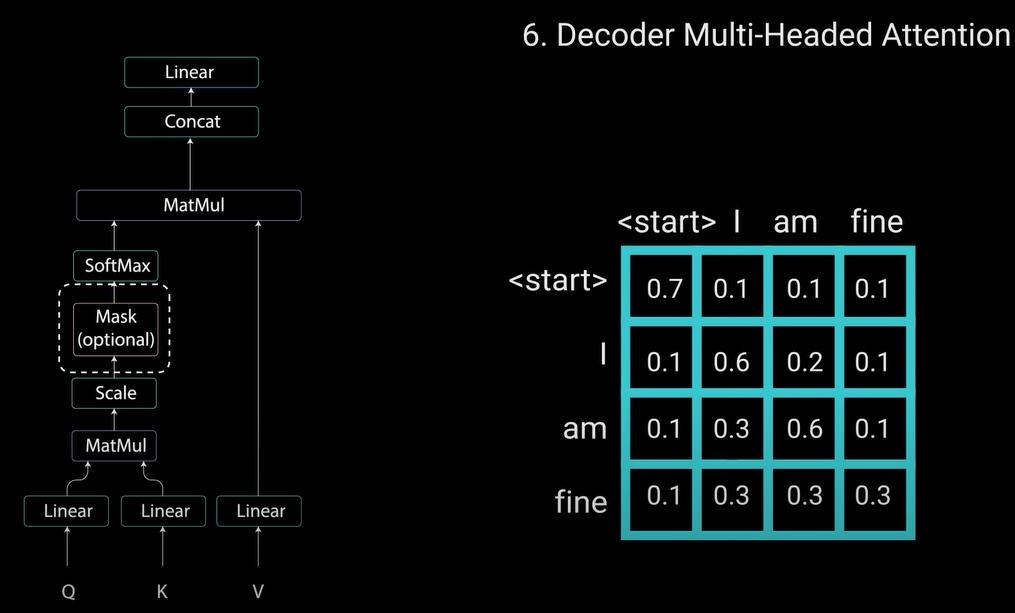

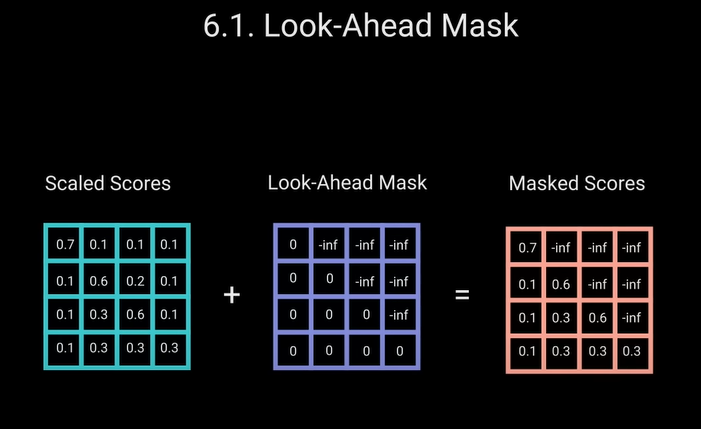

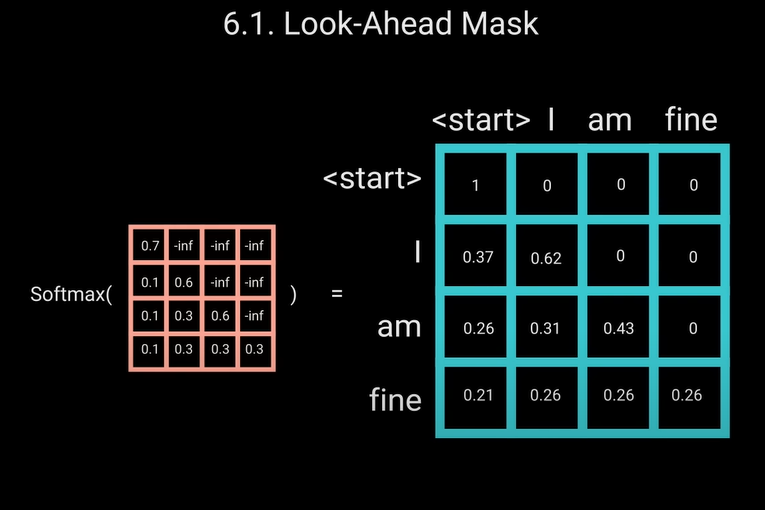

In [ ]:
# version 4: self-attention!
B, T, C = 4, 8, 32  # batch, time, channels
x = torch.randn(B, T, C)

# let's see a single Head perform self-attention
head_size = 16
key = nn.Linear(C, head_size, bias=False)
query = nn.Linear(C, head_size, bias=False)
value = nn.Linear(C, head_size, bias=False)
k = key(x)   # (B, T, 16)
q = query(x) # (B, T, 16)
wei =  q @ k.transpose(-2, -1) # (B, T, 16) @ (B, 16, T) ---> (B, T, T)

tril = torch.tril(torch.ones(T, T))
#wei = torch.zeros((T,T))
wei = wei.masked_fill(tril == 0, float('-inf'))
wei = F.softmax(wei, dim=-1)

v = value(x)
out = wei @ v
#out = wei @ x

out.shape

In [ ]:
wei[0]

Notes:
- Attention is a **communication mechanism**. Can be seen as nodes in a directed graph looking at each other and aggregating information with a weighted sum from all nodes that point to them, with data-dependent weights.
- There is no notion of space. Attention simply acts over a set of vectors. This is why we need to positionally encode tokens.
- Each example across batch dimension is of course processed completely independently and never "talk" to each other
- In an "encoder" attention block just delete the single line that does masking with `tril`, allowing all tokens to communicate. This block here is called a "decoder" attention block because it has triangular masking, and is usually used in autoregressive settings, like language modeling.
- "self-attention" just means that the keys and values are produced from the same source as queries. In "cross-attention", the queries still get produced from x, but the keys and values come from some other, external source (e.g. an encoder module)
- "Scaled" attention additional divides `wei` by 1/sqrt(head_size). This makes it so when input Q,K are unit variance, wei will be unit variance too and Softmax will stay diffuse and not saturate too much. Illustration below

In [ ]:
k = torch.randn(B, T, head_size)
q = torch.randn(B, T, head_size)
wei = q @ k.transpose(-2, -1) * head_size**-0.5

In [ ]:
k.var()

In [ ]:
q.var()

In [ ]:
wei.var()

In [ ]:
torch.softmax(torch.tensor([0.1, -0.2, 0.3, -0.2, 0.5]), dim=-1)

In [ ]:
torch.softmax(torch.tensor([0.1, -0.2, 0.3, -0.2, 0.5]) * 8, dim=-1)  # gets too peaky, converges to one-hot

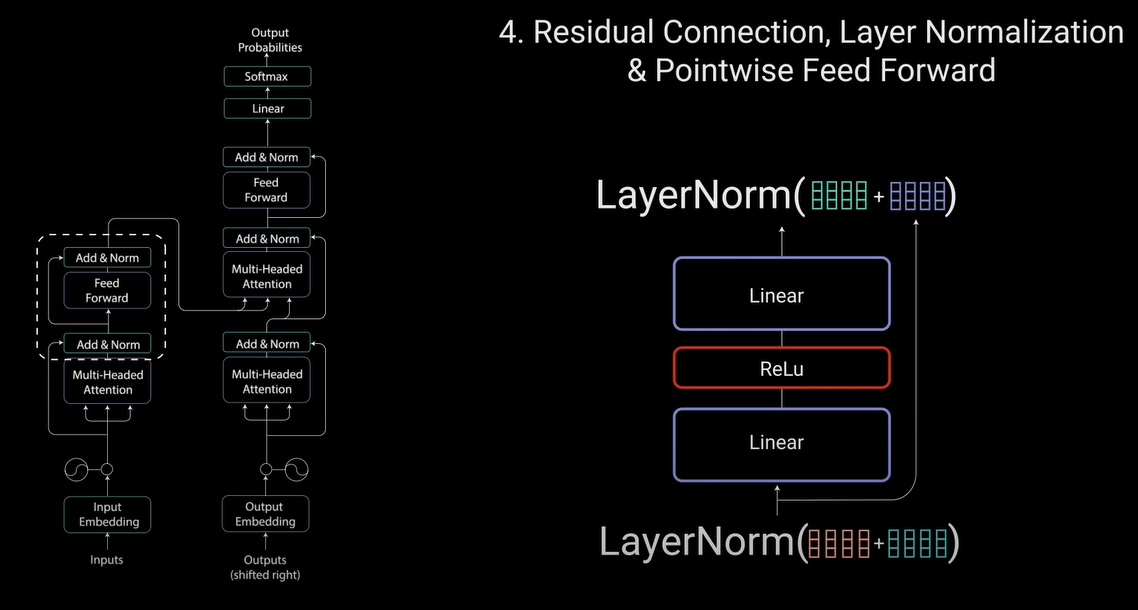

In [ ]:
class LayerNorm1d:  # (used to be BatchNorm1d)

    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)

    def __call__(self, x):
        # calculate the forward pass
        xmean = x.mean(1, keepdim=True)  # batch mean
        xvar = x.var(1, keepdim=True)    # batch variance
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)  # normalize to unit variance
        self.out = self.gamma * xhat + self.beta
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]


module = LayerNorm1d(100)
x = torch.randn(32, 100)  # batch size 32 of 100-dimensional vectors
x = module(x)
x.shape

In [ ]:
x[:,0].mean(), x[:,0].std()  # mean, std of one feature across all batch inputs

In [ ]:
x[0,:].mean(), x[0,:].std()  # mean, std of a single input from the batch, of its features

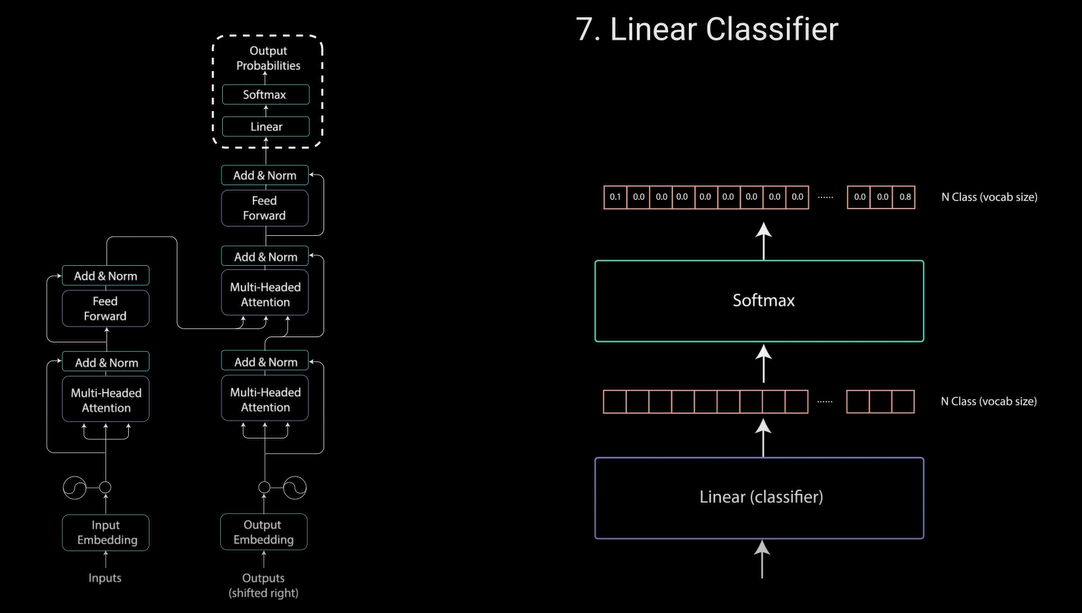

In [ ]:
# French to English translation example:

# <--------- ENCODE ------------------><--------------- DECODE ----------------->
# les réseaux de neurones sont géniaux! <START> neural networks are awesome!<END>

### Full finished code, for reference

You may want to refer directly to the git repo instead though.

In [ ]:
import tqdm

import torch
import torch.nn as nn
from torch.nn import functional as F

torch.manual_seed(42)


# hyperparameters
batch_size = 16 # how many independent sequences will we process in parallel?
block_size = 32 # what is the maximum context length for predictions?
max_iters = 5_000
eval_interval = 100
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 64
n_head = 4
n_layer = 4
dropout = 0.0
# ------------


# All of Petőfi's printed works
with open('/content/drive/MyDrive/Colab Notebooks/petofi_all.txt', 'r', encoding='utf-8') as f:
    text = f.read()

# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)

# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string


# Train and test splits
data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]


# data loading
def get_batch(data, batch_size, block_size):
    # generate a small batch of data of inputs x and targets y
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y


@torch.no_grad()
def estimate_loss(train_data, val_data):
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            data = train_data if split == 'train' else val_data
            X, Y = get_batch(data, batch_size, block_size)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out


class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B, T, C = x.shape
        k = self.key(x)   # (B, T, C)
        q = self.query(x) # (B, T, C)

        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2, -1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)

        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,C)
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)

        return out


class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out


class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)


class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x


# super simple bigram model
class BigramLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B, T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B, T, C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T, C)
        x = tok_emb + pos_emb # (B, T, C)
        x = self.blocks(x) # (B, T, C)
        x = self.ln_f(x) # (B, T, C)
        logits = self.lm_head(x) # (B, T, vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx


model = BigramLanguageModel()
m = model.to(device)
# print the number of parameters in the model
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

In [ ]:
# train the model
max_iters = 5_000
for iter in tqdm.trange(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss(train_data, val_data)
        tqdm.tqdm.write(
            f"  > step {iter}: "
            f"train loss {losses['train']:.4f}, "
            f"val loss {losses['val']:.4f}"
        )

    # sample a batch of data
    xb, yb = get_batch(train_data, batch_size, block_size)

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

In [ ]:
# generate from the model
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(m.generate(context, max_new_tokens=2000)[0].tolist()))

In [ ]:
# custom starting context
context_string = 'Anyám ty'
context = torch.tensor([encode(context_string)], dtype=torch.long, device=device)
print(decode(m.generate(context, max_new_tokens=2000)[0].tolist()))

If you want to play around with a similar generative system, give [huggingface's models](https://transformer.huggingface.co/) a go.

----